# afwTables: A Guided Tour
<br>Owner(s): **Imran Hasan** ([@ih64](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@ih64))
<br>Last Verified to Run: **2020-08-10**
<br>Verified Stack Release: **20.0.0**

Catalogs of astronomical objects and their many  measurements will be a primary data product that LSST provides. Queries of those catalogs will be the starting point for almost all LSST science analyses. On the way to filling the LSST database with these catalogs, the science pipelines will generate and manipulate a lot of internal tables; the python class that the Stack defines and uses for these tables is called an "afwTable". 

### Learning Objectives:

After working through this tutorial you should be able to: 
1. Make a bare bones afw schema and table;
2. Set and get values in a schema and table;
3. Navigate large schemas;
4. Read and write a source detection catalog table;
5. Learn to use source detection catalog methods, and to avoid common pitfalls;
6. Learn to use source match vectors.

### Logistics
This notebook is intended to be runnable on `lsst-lsp-stable.ncsa.illinois.edu` from a local git clone of https://github.com/LSSTScienceCollaborations/StackClub.

## Set-up

The next few cells give you some options for your "Set-up" section - you may not need them all.

We'll need the `stackclub` package to be installed. If you are not developing this package, you can install it using `pip`, like this:
```
pip install git+git://github.com/LSSTScienceCollaborations/StackClub.git#egg=stackclub
```
If you are developing the `stackclub` package (eg by adding modules to it to support the Stack Club tutorial that you are writing, you'll need to make a local, editable installation. In the top level folder of the `StackClub` repo, do:

In [1]:
! cd .. && python setup.py -q develop --user && cd -

/home/kadrlica/notebooks/.beavis/StackClub/Basics


When editing the `stackclub` package files, we want the latest version to be imported when we re-run the import command. To enable this, we need the %autoreload magic command.

In [2]:
%load_ext autoreload
%autoreload 2

You can find the Stack version that this notebook is running by using eups list -s on the terminal command line:

In [3]:
# What version of the Stack am I using?
! echo $HOSTNAME
! eups list -s | grep lsst_distrib

nb-kadrlica-r20-0-0
lsst_distrib          20.0.0     	current v20_0_0 setup


For this tutorial we'll need the following modules:

In [4]:
%matplotlib inline
#%matplotlib ipympl

import os
import warnings
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
from IPython.display import IFrame, display, Markdown
plt.style.use('seaborn-talk')

In [5]:
plt.style.use('seaborn-talk')
import lsst.daf.persistence as dafPersist
import lsst.daf.base as dafBase
import lsst.geom
import lsst.afw.table as afwTable
from astropy.io import ascii

## Your first table

To begin, we will make a bare-bones afw table so that we can clearly showcase some important concepts. First we will make the simplest possible table, by hand. While creating tables by hand will not likely be the standard use case, it is useful from a tutorial standpoint, as it will allow us to excercise some concepts one at a time

In [6]:
# afw tables need a schema to tell the table how its data are organized
# Lets have a look at a simple schema:
min_schema = afwTable.SourceTable.makeMinimalSchema()

In [7]:
# But what is the schema exactly? Printing it out can be informative
print(min_schema)

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
)



Our schema contains 4 Fields: one for each celestial coordinate, an id that uniquely defines it, and a 'parent', which lists the id of the source this source was deblended from. We will deal with the parent column in more detail in a few cells, but for now you can ignore it.

Each field has some accompanying information to go along with it. In addition to its name, we get a helpful docstring describing it. We also get the units that values for this field must have. For example, any value associated with the id key has to be a long integer, and all entries for celestial coordniates have to be instances of an Angle class. We will showcase the Angle class shortly.

If printing out the schema gives you more information that you want, you can get the names. If the names are informative enough, this might be all you need.

In [8]:
min_schema.getNames()

{'coord_dec', 'coord_ra', 'id', 'parent'}

In [9]:
# We can also add another field to the schema, using a call pattern like this:
min_schema.addField("r_mag", type=np.float32, doc="r band flux", units="mag")
# Lets make sure the field was added by printing out the schema once more:
print(min_schema)

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
    (Field['F'](name="r_mag", doc="r band flux", units="mag"), Key<F>(offset=32, nElements=1)),
)



You can also ask for a ordered list of names. In this case where our schema contains only 4 names, there is not a clear advantage. However, we will soon encounter schemas that contain many dozens of names. Sifting through a ordered list of these may be preferable. The ordering here is not alphabetical, but instead mirrors the ordering of these fields in the schema. You can check that is the case by comparing the ordering of output in the next cell to the one above

In [10]:
min_schema.getOrderedNames()

['id', 'coord_ra', 'coord_dec', 'parent', 'r_mag']

> We pause here to point out some caveats. 
1. Schemas are append only. You can add new fields, but you cannot remove them. 
2. The units you use have to be understood by astropy. You can find a list of acceptable units at the bottom of this page http://docs.astropy.org/en/stable/units/index.html#module-astropy.units
3. Specific types are allowed. The short and long of it is you may use floats, ints, longs, strings, Angle objects, and arrays. For more details you can go to the bottom of this page http://doxygen.lsst.codes/stack/doxygen/x_masterDoxyDoc/afw_table.html

Now that we have a schema, we can use it to make a table.


In [11]:
min_table = afwTable.BaseCatalog(min_schema)
# our table is empty, and we can check this by looking at its length
print('our minimal table has {} rows'.format(len(min_table)))

our minimal table has 0 rows


Now we will add some data to our minimal catalog. Catalogs are collections of 'records', which themselves contain data. Therefore, we must first create records, and hand those records over in turn to our Table. Records must adhere to the schema that the Table has, and so we must add data in field by field.

In [12]:
# make a new record.
rec = min_table.addNew()

In [13]:
# grab a hold of the keys for the record. We will use these to add data 
field_dict = min_schema.extract('*') #this returns a dictionary of all the fields
field_dict.keys()

dict_keys(['id', 'coord_ra', 'coord_dec', 'parent', 'r_mag'])

In [14]:
# access the dictionary one field at a time, and grab each field's key. 
# note these are instances of a Key object, and not to be confused with python dictionary keys.
id_key = field_dict['id'].key
ra_key = field_dict['coord_ra'].key
dec_key = field_dict['coord_dec'].key
parent_key = field_dict['parent'].key
r_mag_key = field_dict['r_mag'].key

#use the keys to add data in our record
rec.set(id_key, 1)
rec.set(r_mag_key, 19.0)
rec.set(ra_key, lsst.geom.Angle(.2, units=lsst.geom.radians))
rec.set(dec_key, lsst.geom.Angle(-3.14, units=lsst.geom.radians))
rec.set(parent_key, 0)

Notice to set the ra and dec, we needed to create `geom.Angle` objects for them. The object contains both the value of the angle, and the units the angle is in. The units keyword is set to radians by default, and all the DM code works on radians internally. To keep consistency with this, it is largely considered good pratice to work in radians too, setting the keyword for clarity. 

If you insisted that the angle be in other units, you can set them using the the units keyword. Other typical choices are degrees, arcminutes, arcseconds. You can learn more about `lsst.geom.Angle` objects [here]( http://doxygen.lsst.codes/stack/doxygen/x_masterDoxyDoc/classlsst_1_1geom_1_1_angle.html)

Additionally, we set the parent to zero. This means this record refers to the object before any deblending occoured. Lets look at our table now to see how it stands.

In [15]:
min_table

<class 'lsst.afw.table.BaseCatalog'>
 id coord_ra coord_dec parent r_mag
      rad       rad            mag 
--- -------- --------- ------ -----
  1      0.2     -3.14      0  19.0

We will flesh out the parent column a bit more by adding our next record. Notice we can keep using the keys we defined above. Also notice our second record's parent is listed as 1. This means the object 2 was the result of being deblended from object 1, i.e. object 2 is a child object of object 1.

In [16]:
rec = min_table.addNew()
rec.set(id_key, 2)
rec.set(r_mag_key, 18.5)
rec.set(ra_key, lsst.geom.Angle(3.14, units=lsst.geom.radians))
rec.set(dec_key, lsst.geom.Angle(2.0, units=lsst.geom.radians))
rec.set(parent_key, 1)
min_table

<class 'lsst.afw.table.BaseCatalog'>
 id coord_ra coord_dec parent r_mag
      rad       rad            mag 
--- -------- --------- ------ -----
  1      0.2     -3.14      0  19.0
  2     3.14       2.0      1  18.5

One more caveat to note: in the output in the cell above, the table prints coordinates in radians by default

In [17]:
# your turn. add one more record to our table



In [18]:
# now that we have multiple records in our table, we can select particular ones
# tables support indexing
min_table[1]

<class 'lsst.afw.table.BaseRecord'>
id: 2
coord_ra: 3.14 rad
coord_dec: 2 rad
parent: 1
r_mag: 18.5

In [19]:
# you may iterate over them too
for rec in min_table:
    print(rec.get(id_key))

1
2


In [20]:
# you can grab values from particular records by using our schema keys
min_table[1].get(id_key)

2

## Using source catalogs produced by DM

A more typical use case will be to read in a catalog that is produced by a DM process. We will show how to read in and work with a source catalog from the Twinkles data in the following section. 

### Data access
If you know the path to your source catalog, there is a quick way to read it in. However, it is often more powerful to use the 'data butler' to fetch data for you. The butler knows about camera geometry, sensor characteristics, where data are located, and so forth. Having this anciliary information on hand is often very useful. For completeness we will demonstrate both ways of reading in a source catalog, with the note that it is largely considered better practice to use the data butler. 

The data butler has its own tutorial(s), and so we will defer further details on it until later. For now, you may think of it as an abstraction that allows you to quickly fetch catalogs for you. The user just needs to point the butler to where to look and what to look for.

In [21]:
#our data directory containing some HSC data organized as Butler expects
file_path = '/datasets/hsc/repo/rerun/RC/v20_0_0_rc1/DM-25349-sfm/01327/HSC-Z/output/SRC-0038938-032.fits'
source_cat = afwTable.SourceCatalog.readFits(file_path)

In [22]:
# here's the way to get the same catalog with a butler:
datadir = "/datasets/hsc/repo/rerun/RC/v20_0_0_rc1/DM-25349/"   
butler = dafPersist.Butler(datadir)
#Define a dictionary with the filter, ccd, and visit we wish to view
dataId = {'filter': 'HSC-Z', 'ccd': 32, 'visit': 38938} 
# use the dataId and the 'src' to get the source catalog. 
source_cat = butler.get('src', **dataId)

You can find the path to the file again with the `butler.getURI` function

In [23]:
butler.getUri('src', **dataId)

'/datasets/hsc/repo/rerun/RC/v20_0_0_rc1/DM-25349-sfm/01327/HSC-Z/output/SRC-0038938-032.fits'

A few comments are in order on questions you may be having about the butler, and the previous cell. First, there is no good way to know which `dataId`s exist. That means you have to know ahead of time which `dataId`s it makes sense to use. DM is working hard on fixing this. Second, the string `'src'` refers to a very specific data product in the DM philosophy, which is a catalog that contains _the results of different measurement algorithms on detected sources on an individual CCD image_. We will meet some other catalogs later in the tutorial. For now, lets get to know this `src` catalog.

### afw source catalog schemas

In [24]:
#check its schema. Heads up, the schema is pretty big
source_cat.getSchema()

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
    (Field['Flag'](name="calib_detected", doc="Source was detected as an icSource"), Key['Flag'](offset=32, bit=0)),
    (Field['Flag'](name="calib_psf_candidate", doc="Flag set if the source was a candidate for PSF determination, as determined by the star selector."), Key['Flag'](offset=32, bit=1)),
    (Field['Flag'](name="calib_psf_used", doc="Flag set if the source was actually used for PSF determination, as determined by the"), Key['Flag'](offset=32, bit=2)),
    (Field['Flag'](name="calib_psf_reserved", doc="set if source was reserved from PSF determination"), Key['Flag'](offset=32, bit=3)),
    (Fiel

These schemas tend to be large if many measurement algorithms used. Several algorithms are a part of the base measurement process, like aperature photometry, SDSS shape and centrioid measurements. Other measurements are associated with previous calibration steps, like identifying sources to be candidates for PSF modeling. If deblending was run, several outputs from the process are stored in the table as well. Other measurement processess, like shape measurement processes, are considered extensions. All of these measurements often have many fields and analagous flag fields associated with them. To get a list of names of these high level processes only, we can provide the `topOnly=True` keyword arguement to the `getNames` method we met earlier in the tutorial.

In [25]:
source_cat.getSchema().getNames(topOnly=True)

{'base', 'calib', 'coord', 'deblend', 'ext', 'id', 'parent', 'sky'}

However, this may be too vague. For example, if you ran KSB and HSM shape measurement, both will be lumped into the 'ext' catagory in the output above, but you may wish to search the schema for one in particular. We can use unix-like pattern matching with the `extract()` method to search the schema. This returns a dictionary where the keys are the schema fields whose names match the pattern you specified, and the values are the fields themselves. 

In [26]:
source_cat.getSchema().extract('*HSM*Psf*')

{'ext_shapeHSM_HsmPsfMoments_flag_badCentroid': SchemaItem(key=Key['Flag'](offset=32, bit=17), field=Field['Flag'](name="base_SdssCentroid_flag", doc="General Failure Flag")),
 'ext_shapeHSM_HsmPsfMoments_flag_badCentroid_edge': SchemaItem(key=Key['Flag'](offset=32, bit=18), field=Field['Flag'](name="base_SdssCentroid_flag_edge", doc="Object too close to edge")),
 'ext_shapeHSM_HsmPsfMoments_flag_badCentroid_noSecondDerivative': SchemaItem(key=Key['Flag'](offset=32, bit=19), field=Field['Flag'](name="base_SdssCentroid_flag_noSecondDerivative", doc="Vanishing second derivative")),
 'ext_shapeHSM_HsmPsfMoments_flag_badCentroid_almostNoSecondDerivative': SchemaItem(key=Key['Flag'](offset=32, bit=20), field=Field['Flag'](name="base_SdssCentroid_flag_almostNoSecondDerivative", doc="Almost vanishing second derivative")),
 'ext_shapeHSM_HsmPsfMoments_flag_badCentroid_notAtMaximum': SchemaItem(key=Key['Flag'](offset=32, bit=21), field=Field['Flag'](name="base_SdssCentroid_flag_notAtMaximum", d

Schemas in source catalogs include fields for measurements, and the associated flag fields for those measurements.  To tally how many fields, flag fields, and non-flag fields are contained, we can use several count methods.

In [27]:
nFields = source_cat.schema.getFieldCount()
nFlagFields = source_cat.schema.getFlagFieldCount()
nNonFlagFields = source_cat.schema.getNonFlagFieldCount()
print('the schema contains {} fields, \
{} flags fields and {} non-flag fields'.format(nFields, nFlagFields, nNonFlagFields ))

the schema contains 237 fields, 118 flags fields and 119 non-flag fields


If we are just intested in the field names, we can use the `extract()` method, which supports regex pattern matching. `extract()` returns a python dictionary of key-value pairs, where the keys are the names of the schema fields, and the values are the schema items themselves. We are going to tack on the `keys` method to this dictionary so we just get the ids back.

In [28]:
for k in source_cat.getSchema().extract('*HSM*Psf*').keys():
    print(k)

ext_shapeHSM_HsmPsfMoments_flag_badCentroid
ext_shapeHSM_HsmPsfMoments_flag_badCentroid_edge
ext_shapeHSM_HsmPsfMoments_flag_badCentroid_noSecondDerivative
ext_shapeHSM_HsmPsfMoments_flag_badCentroid_almostNoSecondDerivative
ext_shapeHSM_HsmPsfMoments_flag_badCentroid_notAtMaximum
ext_shapeHSM_HsmPsfMoments_flag_badCentroid_resetToPeak
ext_shapeHSM_HsmPsfMoments_flag_badCentroid_badError
ext_shapeHSM_HsmPsfMoments_x
ext_shapeHSM_HsmPsfMoments_y
ext_shapeHSM_HsmPsfMoments_xx
ext_shapeHSM_HsmPsfMoments_yy
ext_shapeHSM_HsmPsfMoments_xy
ext_shapeHSM_HsmPsfMoments_flag
ext_shapeHSM_HsmPsfMoments_flag_no_pixels
ext_shapeHSM_HsmPsfMoments_flag_not_contained
ext_shapeHSM_HsmPsfMoments_flag_parent_source


If you already know the id of the field you are interested in, schema's have a `find` method that will return the field in question. For example, it is a safe bet that a schema will contain an id field

In [29]:
source_cat.getSchema().find('id')

SchemaItem(key=Key<L>(offset=0, nElements=1), field=Field['L'](name="id", doc="unique ID"))

When we dumped the entire schema, the very bottom of the schema contained fields  are named 'slot_'. These are called aliases in the schema, and can help you deal with any ambiguity in the table. For example, there are several algorithms used to measure the centroid, and many fileds with 'centroid' in their name as a result. If you want to have quick access to one algorithms measurement result, you can set up a slot alias for it. Lets do a working example on the first record in our table.

In [30]:
slot_centroid = source_cat[0].getCentroid()
naive_cent_x, naive_cent_y = (source_cat['base_NaiveCentroid_x'][0], source_cat['base_NaiveCentroid_y'][0])
sdss_cent_x, sdss_cent_y = (source_cat['base_SdssCentroid_x'][0], source_cat['base_SdssCentroid_y'][0])

print('sloan centroid is {}, {}'.format(sdss_cent_x, sdss_cent_y))
print('naive centroid is {}, {}'.format(naive_cent_x, naive_cent_y))
print('slot centroid is {}'.format(slot_centroid))

sloan centroid is 44.0, 4.0
naive centroid is 43.98388771246896, 3.863818835456476
slot centroid is (44, 4)


In [31]:
# aliasing works with other methods
psf_flux_key = source_cat.getPsfFluxSlot().getMeasKey()
id_key = source_cat.getIdKey()

As advertised, the slot centroid and SDSS centroid are the same. We also used some syntactic sugar to access the `naive` centroids and `sdss` centroids, which will be familiar to you if you are an astropy tables user. 

Speaking of astropy tables, you can make an astropy table version of a source catalog:

In [32]:
source_cat.asAstropy()

id,coord_ra,coord_dec,parent,calib_detected,calib_psf_candidate,calib_psf_used,calib_psf_reserved,deblend_nChild,deblend_deblendedAsPsf,deblend_psfCenter_x,deblend_psfCenter_y,deblend_psf_instFlux,deblend_tooManyPeaks,deblend_parentTooBig,deblend_masked,deblend_skipped,deblend_rampedTemplate,deblend_patchedTemplate,deblend_hasStrayFlux,sky_source,base_NaiveCentroid_x,base_NaiveCentroid_y,base_NaiveCentroid_flag,base_NaiveCentroid_flag_noCounts,base_NaiveCentroid_flag_edge,base_NaiveCentroid_flag_resetToPeak,base_SdssCentroid_x,slot_Centroid_x,base_SdssCentroid_y,slot_Centroid_y,base_SdssCentroid_xErr,slot_Centroid_xErr,base_SdssCentroid_yErr,slot_Centroid_yErr,base_SdssCentroid_flag,base_CircularApertureFlux_flag_badCentroid,base_GaussianFlux_flag_badCentroid,base_LocalBackground_flag_badCentroid,base_NaiveCentroid_flag_badInitialCentroid,base_PsfFlux_flag_badCentroid,base_SdssShape_flag_badCentroid,base_Variance_flag_badCentroid,ext_photometryKron_KronFlux_flag_badInitialCentroid,ext_shapeHSM_HsmPsfMoments_flag_badCentroid,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid,ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid,ext_shapeHSM_HsmSourceMoments_flag_badCentroid,slot_Centroid_flag,base_SdssCentroid_flag_edge,base_CircularApertureFlux_flag_badCentroid_edge,base_GaussianFlux_flag_badCentroid_edge,base_LocalBackground_flag_badCentroid_edge,base_NaiveCentroid_flag_badInitialCentroid_edge,base_PsfFlux_flag_badCentroid_edge,base_SdssShape_flag_badCentroid_edge,base_Variance_flag_badCentroid_edge,ext_photometryKron_KronFlux_flag_badInitialCentroid_edge,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_edge,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_edge,ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid_edge,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_edge,slot_Centroid_flag_edge,base_SdssCentroid_flag_noSecondDerivative,base_CircularApertureFlux_flag_badCentroid_noSecondDerivative,base_GaussianFlux_flag_badCentroid_noSecondDerivative,base_LocalBackground_flag_badCentroid_noSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_noSecondDerivative,base_PsfFlux_flag_badCentroid_noSecondDerivative,base_SdssShape_flag_badCentroid_noSecondDerivative,base_Variance_flag_badCentroid_noSecondDerivative,ext_photometryKron_KronFlux_flag_badInitialCentroid_noSecondDerivative,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid_noSecondDerivative,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_noSecondDerivative,slot_Centroid_flag_noSecondDerivative,base_SdssCentroid_flag_almostNoSecondDerivative,base_CircularApertureFlux_flag_badCentroid_almostNoSecondDerivative,base_GaussianFlux_flag_badCentroid_almostNoSecondDerivative,base_LocalBackground_flag_badCentroid_almostNoSecondDerivative,base_NaiveCentroid_flag_badInitialCentroid_almostNoSecondDerivative,base_PsfFlux_flag_badCentroid_almostNoSecondDerivative,base_SdssShape_flag_badCentroid_almostNoSecondDerivative,base_Variance_flag_badCentroid_almostNoSecondDerivative,ext_photometryKron_KronFlux_flag_badInitialCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmShapeRegauss_flag_badCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmSourceMomentsRound_flag_badCentroid_almostNoSecondDerivative,ext_shapeHSM_HsmSourceMoments_flag_badCentroid_almostNoSecondDerivative,slot_Centroid_flag_almostNoSecondDerivative,base_SdssCentroid_flag_notAtMaximum,base_CircularApertureFlux_flag_badCentroid_notAtMaximum,base_GaussianFlux_flag_badCentroid_notAtMaximum,base_LocalBackground_flag_badCentroid_notAtMaximum,base_NaiveCentroid_flag_badInitialCentroid_notAtMaximum,base_PsfFlux_flag_badCentroid_notAtMaximum,base_SdssShape_flag_badCentroid_notAtMaximum,base_Variance_flag_badCentroid_notAtMaximum,ext_photometryKron_KronFlux_flag_badInitialCentroid_notAtMaximum,ext_shapeHSM_HsmPsfMoments_flag_badCentroid_notAtMaximum,ext_

In this vein, you may find it more convenient to grab columns from the table and work with them as numpy arrays. As we mentioned above, the defacto unit choice of DM is radians. If you would prefer degrees, you can do something like this

In [33]:
ra_deg = np.rad2deg(source_cat['coord_ra'])

Now we will set aside the schema for this table, and look at the table itself so we can examine its methods.

### afw source catalogs

Source catalogs support a lot of fast operations for common use cases which we will now discuss. 

In [34]:
# Sorting is supported. by default catalogs are sorted by id
source_cat.isSorted(id_key)

True

In [35]:
# Find aperture flux columns
[k for k in source_cat.getSchema().extract('*ApFlux*').keys()]

['slot_ApFlux_instFlux',
 'slot_ApFlux_instFluxErr',
 'slot_ApFlux_flag',
 'slot_ApFlux_flag_apertureTruncated',
 'slot_ApFlux_flag_sincCoeffsTruncated']

In [36]:
# You can cut on the catalog.
# e.g. Make a boolean array to only keep sources with positive psf flux:
psf_mask = source_cat['slot_PsfFlux_instFlux'] > 0
psf_mask &= np.isfinite(source_cat['slot_ApFlux_instFlux'])
psf_mask &= np.isfinite(source_cat['slot_ApFlux_instFluxErr'])
psf_mask &= np.isfinite(source_cat['base_ClassificationExtendedness_value'])
pos_flux = source_cat.subset(psf_mask)

# You can sort on other keys too:
flux_key = pos_flux.getPsfFluxSlot().getMeasKey()
pos_flux.sort(flux_key)
pos_flux.isSorted(flux_key)

True

In [37]:
# You can get the children of particular objects.
# This is useful if you want to understand how one object was deblended, for example:
source_cat.getChildren(33447624753285130) #the argument is the id of the parent object

# Note that this will only work if the source catalog is sorted on id or parent

<class 'lsst.afw.table.SourceCatalog'>
        id             coord_ra          coord_dec             parent      calib_detected ... base_FootprintArea_value calib_astrometry_used calib_photometry_used calib_photometry_reserved
                         rad                rad                                           ...           pix                                                                                 
----------------- ----------------- -------------------- ----------------- -------------- ... ------------------------ --------------------- --------------------- -------------------------
33447624753286194 5.924126308895389 0.020194880465098913 33447624753285130          False ...                      375                 False                 False                     False
33447624753286195 5.924154591501439 0.020201129058987497 33447624753285130          False ...                      424                 False                 False                     False
3344762475328619

You can check if catalogs are contiguous in memory.

In [38]:
source_cat.isContiguous()

True

In [39]:
pos_flux.isContiguous()

False

Some operations are quicker if catalogs are contiguous in memory, like using numpy-like syntax to create masks. Eli Rykoff performed some benchmark tests showing this is the case for a catalog with about half a million enteries. You can find the full details in a Slack thread [here](https://lsstc.slack.com/archives/C2JPL2DGD/p1525799998000344). Additionally, certain operations will not work on non-contiguous tables.

In [40]:
# uncomment the last line if you are curious and want to prove it wont work
# this will not work and give you an error message complaining pos_flux is not contiguous
# pos_flux.asAstropy()

You can always force a table to be contiguous by making a deep copy of it. 

In [41]:
pos_flux = pos_flux.copy(deep=True)
pos_flux.isContiguous()

True

In the next few cells, we show a few methods that can be used to search through tables

In [42]:
# Use the between method to get the indices of values within a range:
pos_flux.between(1e4,1e5,psf_flux_key)

slice(2034, 2312, 1)

In [43]:
# The slice object tells you the (start, stop, stride) for values that fit our query.
# You can check to see that the first record outside the slice is above the flux threshold
pos_flux[2033].get(psf_flux_key)

9948.867354290986

In [44]:
# and that the last element in the slice is inside the threshold
pos_flux[2311].get(psf_flux_key)

99696.53468723795

In [45]:
# your turn. confirm the lower limits of the between query
# pos_flux[...].getPsfFlux


In [46]:
#the upper and lower bound methods work similarly
pos_flux.upper_bound(1e4, psf_flux_key)

2034

In [47]:
pos_flux.lower_bound(1e5, psf_flux_key)

2312

## Example: Star-Galaxy Separation

Now that we have introduced the functionality of the source catalog and its schema, we will do a toy example of star-galaxy separation. This small demo will also flags and fields that users are use, and ultimately make a plot.

In [48]:
# let's select sources that were not deblended
select_mask = source_cat['deblend_nChild'] == 0
select_mask &= source_cat['parent'] == 0

# use the extendedness column for a mock star/galaxy seperation
# we only want to use columns where this algorithm worked
# the flag is set true if there was a failure, so we invert the flag values here
select_mask &= ~source_cat['base_ClassificationExtendedness_flag']

# we will also use the sloan shapes to measure size
select_mask &= ~source_cat['base_SdssShape_flag']

# and a simple aperture flux for the brightness
select_mask &= ~source_cat['base_CircularApertureFlux_12_0_flag']

# only consider sources with positive flux
select_mask &= source_cat['base_CircularApertureFlux_12_0_instFlux'] > 0

size_bright_cat = source_cat.subset(select_mask)

Now we make a crude size magnitude diagram, color coding the data by their 'extendedness value'. The extendedness will be 1 for extended sources-like galaxies-and 0 for point sources-like stars. One hopes the stars will all live on the stellar locus...

(5.0, 15.0)

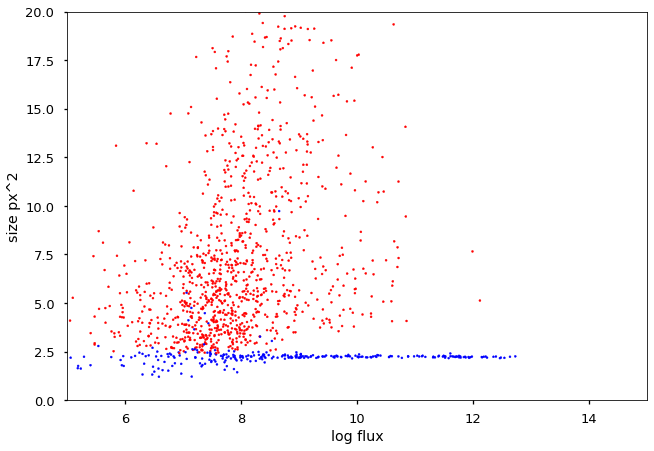

In [49]:
plt.scatter(np.log(size_bright_cat['base_CircularApertureFlux_12_0_instFlux']), 
           size_bright_cat['base_SdssShape_xx'] + size_bright_cat['base_SdssShape_yy'],
           c=size_bright_cat['base_ClassificationExtendedness_value'],
            cmap='bwr',
           s=4)
plt.xlabel('log flux')
plt.ylabel('size px^2')
plt.ylim([0,20]) #zoom in to make the stellar locus clearer
plt.xlim([5,15])

Our plot shows some star galaxy separation, but also has other interesting features. Some detected sources appear to be smaller than the PSF, some of the point sources have a (crudely) calculated size that occupy the same parameter space as extended sources, and there are a few extremely faint detected point sources. We will leave it to you to delve into this mystery further as a homework assignment since we are primarily focused on understanding tables in this tutorial. By making this plot we exercised some of the methods of the catalog and its schema, to do a minimal analysis example.

### Operations with multiple tables/catalogs

In the next section we will show operations which involve two or more catalogs.

#### Table concatenation

In [50]:
# Grab a second catalog using the butler:
dataId2 = {'filter': 'HSC-Z', 'ccd': 31, 'visit': 38938}
source_cat2 = butler.get('src', dataId2)

# Put our catalogs in a list:
catalogList = [source_cat, source_cat2]

# The following concatenation function is courtesy of Jim Bosch:
def concatenate(catalogList):
    from functools import reduce
    """Concatenate multiple catalogs (FITS tables from lsst.afw.table)"""
    schema = catalogList[0].schema
    for i, c in enumerate(catalogList[1:]):
        #check that the schema in the tables are the same
        #we can only cat them if this is true
        if c.schema != schema:
            raise RuntimeError("Schema for catalog %d not consistent" % (i+1))

    # prepare the master catalog
    out = afwTable.BaseCatalog(schema)
    num = reduce(lambda n, c: n + len(c), catalogList, 0)
    # set aside enough space for all the records and their pointers
    out.reserve(num)

    # stick in all the records from all catalogs into the master catalog
    for catalog in catalogList:
        for record in catalog:
            out.append(out.table.copyRecord(record))

    return out

cat_source = concatenate(catalogList)

#### Catalog matching

Quick positional matching is supported by the stack, and offers some useful functionality. In the next example, we will match two overlapping HSC observations from different filters together. Getting this data will require us to use a new data repository, so we will have to set up a new butler, then ask for our two tables

In [51]:
depth = 'WIDE' # WIDE, DEEP, UDEEP
field = 'SSP_WIDE' # SSP_WIDE, SSP_DEEP, SSP_UDEEP
butler = dafPersist.Butler('/datasets/hsc/repo/rerun/DM-13666/%s/'%(depth))

Let's grab some forced photometry for the HSC-I band and the HSC-R band. They will have the same tract and patch, which ensures they will overlap

In [52]:
objects = []
for filter in ("HSC-I", "HSC-R"):
    objects.append(butler.get("deepCoadd_forced_src", dataId={'filter':filter, 'field':field, 'tract':15830, 'patch':'0,3'}))
iSources, rSources = objects

We will need these calib objects for our two bands so that we can calculate magnitudes a little later

In [53]:
calibs = []
for filter in ("HSC-I", "HSC-R"):
    calibs.append(butler.get("deepCoadd_calexp_photoCalib", dataId={'filter':filter, 'field':field, 'tract':15830, 'patch':'0,3'}))
iCalib, rCalib = calibs

Some quality control flags to prune down the data to give us stars with a signal to noise ratio of 10 or higher. We will use this to index into our catalogs when we do the matching. Note that because these are forced photometry catalogs, the records in each catalog line up so that they should be refering to the same astrophysical sources. That is why we will be able to use our mask on both iSources and rSources. This is not true in general of afwTables.

In [54]:
noChildren = iSources['deblend_nChild'] == 0
isGoodFlux = ~iSources['modelfit_CModel_flag']
isStellar = iSources['base_ClassificationExtendedness_value'] < 1.
snr = iSources['modelfit_CModel_instFlux']/iSources['modelfit_CModel_instFluxErr'] > 10

star_flag = noChildren & isGoodFlux & isStellar & snr

/opt/lsst/software/stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-1a1d771/lib/python3.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in greater


In order to match catalogs, we must provide a `MatchControl` instance. The `MatchControl` provides configurations for catalog matching. It has three 'switches' in the form of class attributes. They are defined as follows:

1. `findOnlyClosest`: True by default. If False, all other sources within a search radius are also matched 
2. `includeMismatches`: False by default. If False, sources with no match are not reported in the match catalog. If True, sources with no match are included in the match catalog with Null as their match
3. `symmetricMatch`: False by default. If False, the match between source a from catalog a with source b from catalog b is reported alone. If True, the symmetric match between source b and a is also reported.

In [55]:
# get a match control, we will keep the default configuration
mc = afwTable.MatchControl()

# match our two catalogs, setting the match threshold to be one arcsecond
matches = afwTable.matchRaDec(iSources[star_flag], rSources[star_flag],
                              lsst.geom.Angle(1,lsst.geom.arcseconds), mc)

`afwTable.matchRaDec` returns a list, where each element is an instance of a `Match` class. The `Match` class has three attributes, which gives us information about the matched sources. Let us unpack this a bit before moving on to some analysis

In [56]:
# how many sources were actually matched?
len(matches)

696

In [57]:
# lets examine the first element in the matches list
# we can grab the record corresponding to this source in the i band catalog
# using the first attribute
matches[0].first

<class 'lsst.afw.table.SourceRecord'>
id: 69621089155700649
coord_ra: 4.25365 rad
coord_dec: 0.734943 rad
parent: 69621089155678244
deblend_nChild: 0
base_SdssCentroid_x: 1079.88
base_SdssCentroid_y: 11941.8
base_SdssCentroid_xSigma: 0.156168
base_SdssCentroid_ySigma: 0.174856
base_SdssCentroid_flag: 0
base_SdssCentroid_flag_edge: 0
base_SdssCentroid_flag_noSecondDerivative: 0
base_SdssCentroid_flag_almostNoSecondDerivative: 0
base_SdssCentroid_flag_notAtMaximum: 0
base_SdssCentroid_flag_resetToPeak: 0
base_TransformedCentroid_x: 1079.88
base_TransformedCentroid_y: 11941.8
base_TransformedCentroid_flag: 0
base_InputCount_flag: 0
base_InputCount_value: 3
base_InputCount_flag_noInputs: 0
base_SdssShape_xx: 1.01038
base_SdssShape_yy: 1.15645
base_SdssShape_xy: 0.179421
base_SdssShape_xxSigma: 0.256862
base_SdssShape_yySigma: 0.196973
base_SdssShape_xySigma: 0.293995
base_SdssShape_x: 1079.89
base_SdssShape_y: 11941.8
base_SdssShape_flux: 4.63007
base_SdssShape_fluxSigma: 0.588534
base_Sds

In [58]:
# likewise the second attribute gives us the record from the r band catalog
matches[0].second

<class 'lsst.afw.table.SourceRecord'>
id: 69621089155700649
coord_ra: 4.25365 rad
coord_dec: 0.734943 rad
parent: 69621089155678244
deblend_nChild: 0
base_SdssCentroid_x: 1080.12
base_SdssCentroid_y: 11941.7
base_SdssCentroid_xSigma: 0.538286
base_SdssCentroid_ySigma: 1.67512
base_SdssCentroid_flag: 0
base_SdssCentroid_flag_edge: 0
base_SdssCentroid_flag_noSecondDerivative: 0
base_SdssCentroid_flag_almostNoSecondDerivative: 0
base_SdssCentroid_flag_notAtMaximum: 0
base_SdssCentroid_flag_resetToPeak: 0
base_TransformedCentroid_x: 1079.88
base_TransformedCentroid_y: 11941.8
base_TransformedCentroid_flag: 0
base_InputCount_flag: 0
base_InputCount_value: 4
base_InputCount_flag_noInputs: 0
base_SdssShape_xx: 3.55838
base_SdssShape_yy: 2.91767
base_SdssShape_xy: 0.129322
base_SdssShape_xxSigma: 1.61242
base_SdssShape_yySigma: 1.03325
base_SdssShape_xySigma: 1.3221
base_SdssShape_x: 1080
base_SdssShape_y: 11941.8
base_SdssShape_flux: 2.35406
base_SdssShape_fluxSigma: 0.533353
base_SdssShape_p

In [59]:
#finally the angular seperation is given in radians in the distance attribute
matches[0].distance

0.0

Now that we have matched stars in two bands, lets make a color magnitude diagram, displaying how to use matches in a little more depth
first we start out simple and demonstrate how to get the magnitude and magnitude error for one record in our matches object

In [60]:
# use the calib object to get magnitudes
# pass in a record and the name of the flux field you are interested in
iCalib.instFluxToMagnitude(matches[0].first, 'modelfit_CModel')

Measurement(value=25.12605024911535878, error=0.0975758478808133739)

Text(0, 0.5, '$i$')

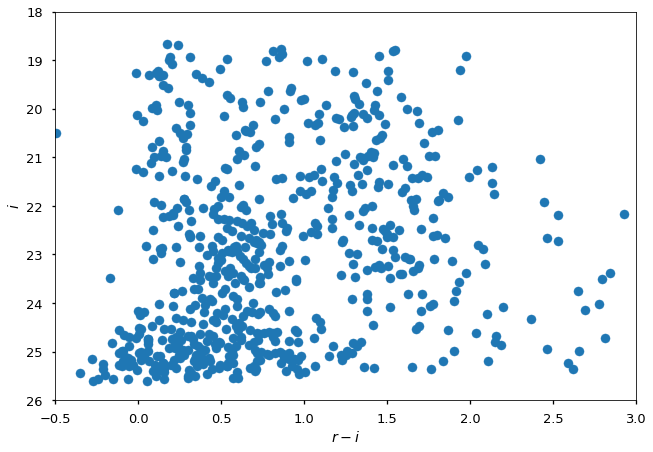

In [61]:
# now we make some loops to grab all the magnitudes in the iband and rband
# remember that the i band catalog is accessed with the first attribute
# and the r band catalog is accessed with the second attribute
iMag = [iCalib.instFluxToMagnitude(m.first, 'modelfit_CModel').value for m in matches]
rMag = [rCalib.instFluxToMagnitude(m.second, 'modelfit_CModel').value for m in matches]

plt.scatter(np.array(rMag) - (iMag), iMag)
plt.ylim([26,18])
plt.xlim([-0.5,3])
plt.xlabel('$r-i$')
plt.ylabel('$i$')

If you are only interested in the ids and the angular separation, you can pack the matches into a table.

In [62]:
matches_table = afwTable.packMatches(matches)
matches_table

<class 'lsst.afw.table.BaseCatalog'>
      first             second      distance
----------------- ----------------- --------
69621089155700649 69621089155700649      0.0
69621089155678312 69621089155678312      0.0
69621089155700954 69621089155700954      0.0
69621089155700960 69621089155700960      0.0
69621089155678310 69621089155678310      0.0
69621089155700840 69621089155700840      0.0
69621089155700920 69621089155700920      0.0
69621089155700961 69621089155700961      0.0
69621089155700988 69621089155700988      0.0
69621089155701062 69621089155701062      0.0
69621089155700979 69621089155700979      0.0
69621089155701065 69621089155701065      0.0
69621089155701014 69621089155701014      0.0
69621089155701058 69621089155701058      0.0
69621089155701090 69621089155701090      0.0
69621089155701061 69621089155701061      0.0
69621089155678456 69621089155678456      0.0
69621089155701008 69621089155701008      0.0
69621089155701056 69621089155701056      0.0
69621089155701127 

You can unpack the matches too:

In [63]:
unpack_matches = afwTable.unpackMatches(matches_table, iSources, rSources)

Hopefully this gives you some idea of the power of `afwTable`s in matching catalogs together

## Summary

In this tutorial we introduced afw tables. We introduced schemas, how to navigate them, add to them, and how to create tables based off of them. We covered data access to catalogs produced by DM using the data butler. We went over a some typical use cases for source catalogs, like catalog matching, and understanding bread and butter measurement algorithms.